# SLIM MODEL
Since the KNN_Item_CF is the one that perfomed the best so far, now i'm trying a SLIM Model, which is basically the same algorithm but Machine Learning based. It uses the infos from the training data instead of some heuristic (such as cosine similarity ecc...)
https://notebook.community/trangel/Insight-Data-Science/general-docs/recommendation-validation/.ipynb_checkpoints/recommender_systems-validation-checkpoint

# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [3]:
unique_users, min_users, max_users = len(dataset.row.unique()), dataset.row.min(), dataset.row.max()
unique_items, min_items, max_items = len(dataset.col.unique()), dataset.col.min(), dataset.col.max()
print('users stats:',unique_users, min_users, max_users)
print('items stats:',unique_items, min_items, max_items)

users stats: 7947 0 7946
items stats: 24896 0 25974


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [4]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

CSR basically has a pointer to the exact beginning of every possible row. For example if i have <code>matrix.inptr = [0,1,2,4,6] </code> this means that at <code>matrix.inptr[n]</code> I have my n row which "last" until the next cell in the array. <br> In this case (for example) my third row goes from 2 to 4. <br>

What do I do with it? <br>

I use this index (2 to 4) to access the other two arrays of the crs format: <code>indices</code> and <code>data</code>.
<code>indices</code> gives me the column index and <code>data</code> gives me the actual data to take

In [5]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [6]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

The following 2 graphs plots the <code>items_per_user</code> and the <code>users_per_item</code>. It shows that slightly more than 2500 users and 2500 items have a 0 count. This is coherent with the original data we got: 30910-27255 for users and 18494-15277 for items. These differences are the missing users/items in the dataset (Basically users/items that have no interaction at all)

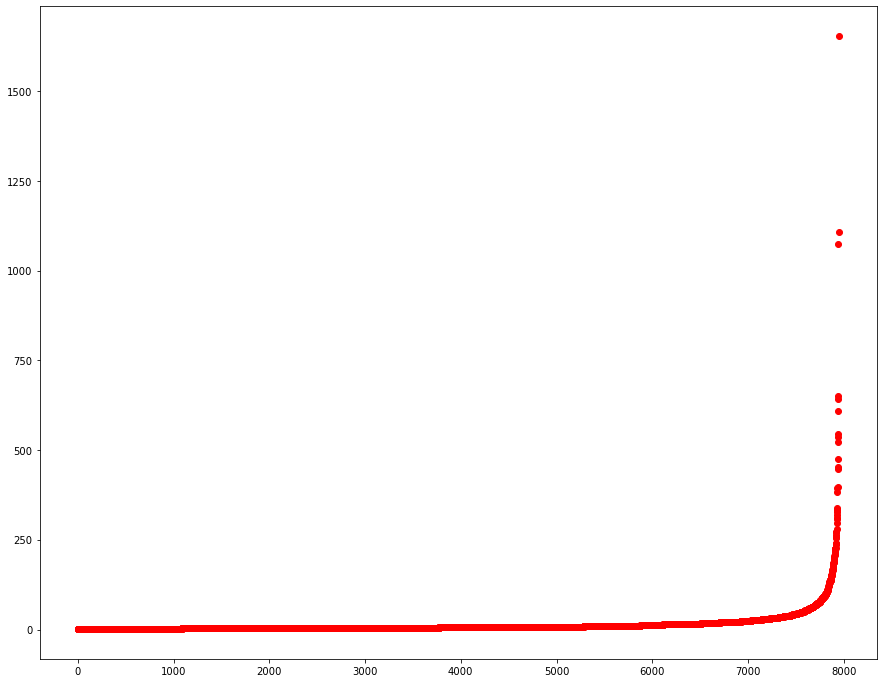

In [7]:
plt.figure(figsize=(15,12))
plt.plot(items_per_user, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

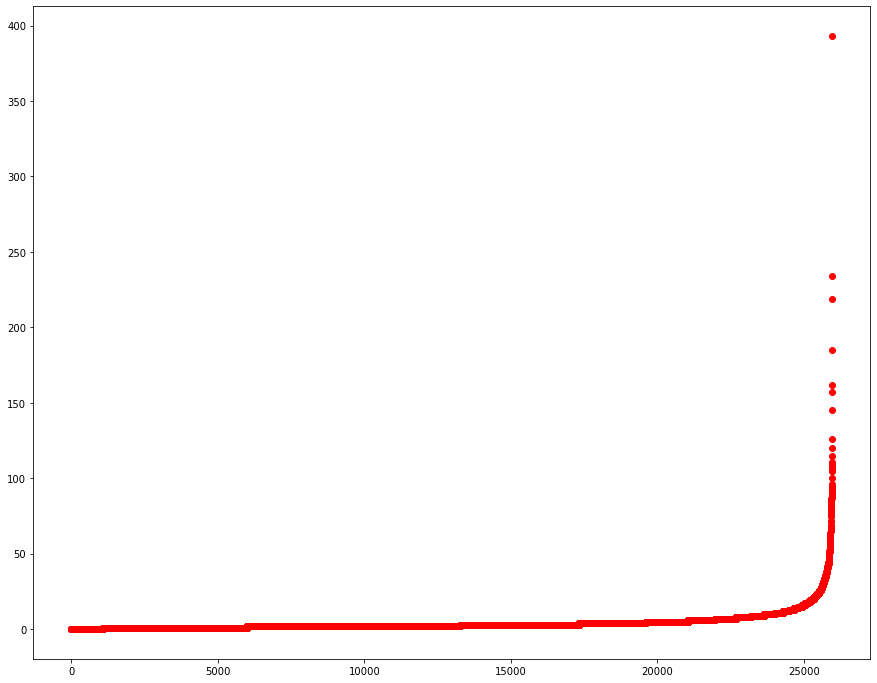

In [8]:
plt.figure(figsize=(15,12))
plt.plot(users_per_item, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

In [9]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [10]:
unique_items, min_items, max_items = len(ICM_df.row.unique()), ICM_df.row.min(), ICM_df.row.max()
unique_features, min_features, max_features = len(ICM_df.col.unique()), ICM_df.col.min(), ICM_df.col.max()
print('items stats:',unique_items, min_items, max_items)
print('features stats:',unique_features, min_features, max_features)

items stats: 25950 0 25974
features stats: 19998 0 19999


In [11]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [12]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [13]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

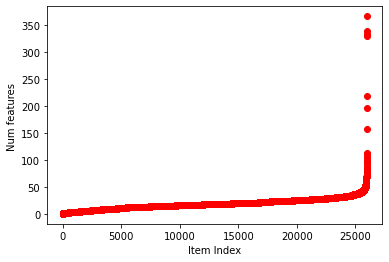

In [14]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

plt.plot(features_per_item, 'ro')
plt.ylabel('Num features ')
plt.xlabel('Item Index')
plt.show()

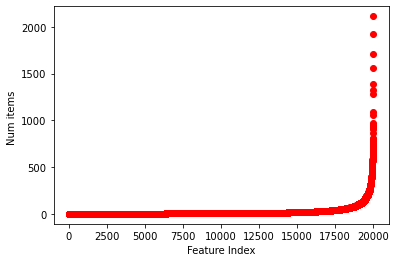

In [15]:
plt.plot(items_per_feature, 'ro')
plt.ylabel('Num items ')
plt.xlabel('Feature Index')
plt.show()

In [16]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test. In teoria non serve, da vedere
#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [17]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [18]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.ItemKNNScoresHybridRecommender import ItemKNNScoresHybridRecommender

recommender_alpha = P3alphaRecommender(URM_train)
recommender_alpha.fit(topK=475, alpha = 0.45, implicit = True)

recommender_alpha_ICM = P3alphaRecommender(ICM_all.T)
recommender_alpha_ICM.fit(topK=175, alpha = 0.45)
recommender_alpha_ICM.URM_train = URM_train

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(topK=70, alpha=0.4, beta=0.2, implicit=True)


P3alphaRecommender: URM Detected 40 (0.50 %) cold users.
P3alphaRecommender: URM Detected 2008 (7.73 %) cold items.
P3alphaRecommender: URM Detected 2 (0.01 %) cold users.
P3alphaRecommender: URM Detected 25 (0.10 %) cold items.
RP3betaRecommender: URM Detected 40 (0.50 %) cold users.
RP3betaRecommender: URM Detected 2008 (7.73 %) cold items.


In [19]:
hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha_ICM.W_sparse, recommender_alpha.W_sparse)
hybridrecommender.fit(topK=600, alpha = 0.45)

hybridrecommender_final = ItemKNNScoresHybridRecommender(URM_train, hybridrecommender, recommender_rp3)
hybridrecommender_final.fit(alpha = 0.45)



ItemKNNSimilarityHybridRecommender: URM Detected 40 (0.50 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 2008 (7.73 %) cold items.
ItemKNNScoresHybridRecommender: URM Detected 40 (0.50 %) cold users.
ItemKNNScoresHybridRecommender: URM Detected 2008 (7.73 %) cold items.


In [20]:
evaluator_validation.evaluateRecommender(hybridrecommender_final)

shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (13, 25975)
EvaluatorHoldout: Processed 5013 ( 100.00% ) in 4.95 sec. Users per second: 1012


({10: {'ROC_AUC': 0.19267154604377848,
   'PRECISION': 0.038380211450228484,
   'PRECISION_RECALL_MIN_DEN': 0.1575425322732331,
   'RECALL': 0.15473302590024532,
   'MAP': 0.07444785212516475,
   'MRR': 0.13911069315019056,
   'NDCG': 0.10897123899200102,
   'F1': 0.06150470401578118,
   'HIT_RATE': 0.383802114502294,
   'ARHR': 0.15715093138791547,
   'NOVELTY': 0.004942081411682915,
   'AVERAGE_POPULARITY': 0.0963228144138671,
   'DIVERSITY_MEAN_INTER_LIST': 0.9876319573896377,
   'DIVERSITY_HERFINDAHL': 0.9987434943234962,
   'COVERAGE_ITEM': 0.4662175168431184,
   'COVERAGE_ITEM_CORRECT': 0.04592877767083734,
   'COVERAGE_USER': 0.6308040770101925,
   'COVERAGE_USER_CORRECT': 0.18761796904492262,
   'DIVERSITY_GINI': 0.1698522584735186,
   'SHANNON_ENTROPY': 11.818389179794096}},
 'CUTOFF: 10 - ROC_AUC: 0.1926715, PRECISION: 0.0383802, PRECISION_RECALL_MIN_DEN: 0.1575425, RECALL: 0.1547330, MAP: 0.0744479, MRR: 0.1391107, NDCG: 0.1089712, F1: 0.0615047, HIT_RATE: 0.3838021, ARHR: 0

In [21]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [22]:
recommender_alpha = P3alphaRecommender(URM_all)
recommender_alpha.fit(topK=475, alpha = 0.45, implicit = True)

recommender_alpha_ICM = P3alphaRecommender(ICM_all.T)
recommender_alpha_ICM.fit(topK=175, alpha = 0.45)
recommender_alpha_ICM.URM_train = URM_train

hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_all, recommender_alpha_ICM.W_sparse, recommender_alpha.W_sparse)
hybridrecommender.fit(topK=600, alpha = 0.45)

hybridrecommender_final = ItemKNNScoresHybridRecommender(URM_all, hybridrecommender, recommender_rp3)
hybridrecommender_final.fit(alpha = 0.45)

user_id = test_users['user_id']
recommendations = hybridrecommender.recommend(user_id,cutoff = 10)


P3alphaRecommender: URM Detected 1079 (4.15 %) cold items.
P3alphaRecommender: URM Detected 2 (0.01 %) cold users.
P3alphaRecommender: URM Detected 25 (0.10 %) cold items.
ItemKNNSimilarityHybridRecommender: URM Detected 1079 (4.15 %) cold items.
ItemKNNScoresHybridRecommender: URM Detected 1079 (4.15 %) cold items.


In [23]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [24]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
